# MNIST Digit Recognition Using Keras

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import gzip
import numpy as np
import time
import os
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten
from keras.optimizers import Adam
from keras.models import load_model

/home/behailu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Data

    load MNIST Data to list

In [2]:
# filename for the dataset
filename_x_train = "train-images-idx3-ubyte.gz"
filename_y_train = "train-labels-idx1-ubyte.gz"
filename_x_test = "t10k-images-idx3-ubyte.gz"
filename_y_test = "t10k-labels-idx1-ubyte.gz"

# MNIST images are 28 pixels in each dimension.
img_size = 28

# Store the images in one-dimensional list of length:
img_size_flat = img_size * img_size

# The height and width of the image.
img_shape = (img_size, img_size)

# number of colour channels. 
num_channels = 1

# Tuple with height, width and depth
img_shape_full = (img_size, img_size, num_channels)

# Number of digit that will be recognized
num_classes = 10

In [3]:
# Data folder
data_dir = "../Handwritten_Recognition/MNIST/"

In [4]:
# Number of images in each subset
num_train = 55000
num_val = 5000
num_test = 10000

def _load_data(filename, offset):
        """
        Load the data in the given file. Automatically downloads the file
        if it does not already exist in the data_dir.

        :param filename: Name of the data-file.
        :param offset: Start offset in bytes when reading the data-file.
        :return: The data as a numpy array.
        """

        # Read the data-file.
        path = os.path.join(data_dir, filename)
        with gzip.open(path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=offset)

        return data

# Load the data
def _load_images(filename):
        """
        Load image-data from the given file.
        Automatically downloads the file if it does not exist locally.

        :param filename: Name of the data-file.
        :return: Numpy array.
        """

        # Read the data as one long array of bytes.
        data = _load_data(filename=filename, offset=16)

        # Reshape to 2-dim array with shape (num_images, img_size_flat).
        images_flat = data.reshape(-1, img_size_flat)

        return images_flat
def _load_cls( filename):
        """
        Load class-numbers from the given file.
        Automatically downloads the file if it does not exist locally.

        :param filename: Name of the data-file.
        :return: Numpy array.
        """
        return _load_data(filename=filename, offset=8)
def random_batch(batch_size=32):
        """
        Create a random batch of training-data.

        :param batch_size: Number of images in the batch.
        :return: 3 numpy arrays (x, y, y_cls)
        """

        # Create a random index into the training-set.
        idx = np.random.randint(low=0, high=num_train, size=batch_size)

        # Use the index to lookup random training-data.
        x_batch = x_train[idx]
        y_batch = y_train[idx]
        y_batch_cls = y_train_cls[idx]

        return x_batch, y_batch, y_batch_cls
# load training and validation data
x_train = _load_images(filename = filename_x_train)
y_train_cls = _load_cls(filename = filename_y_train)
# split the training set into train and validation
# convert pixel values into from ints b/n 0 and 255 to 0.0 and 1.0
x_train = x_train[0:num_train] / 255.0
x_val = x_train[num_train:] / 255.0
y_train_cls = y_train_cls[0:num_train]
y_val_cls = y_train_cls[num_train:]

# load test data
x_test = _load_images(filename=filename_x_test) / 255.0
y_test_cls = _load_cls(filename = filename_y_test)

# convert the class numbers from bytes to ints as that is needed for Tensorflow
y_train_cls = y_train_cls.astype(np.int)
y_val_cls = y_val_cls.astype(np.int)
y_test_cls = y_test_cls.astype(np.int)

# function for one hot encoding
def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.

    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]

    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.

    :param num_classes:
        Number of classes. If None then use max(class_numbers)+1.

    :return:
        2-dim array of shape: [len(class_numbers), num_classes]
    """

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]

# Convert the integers class-numbers into one-hot encoded list.
y_train = one_hot_encoded(class_numbers = y_train_cls,
                         num_classes = num_classes)
y_val = one_hot_encoded(class_numbers = y_val_cls,
                       num_classes = num_classes)
y_test = one_hot_encoded(class_numbers = y_test_cls,
                        num_classes = num_classes)

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(num_train))
print("- Validation-set:\t{}".format(num_val))
print("- Test-set:\t\t{}".format(num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [6]:
# function for ploting images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

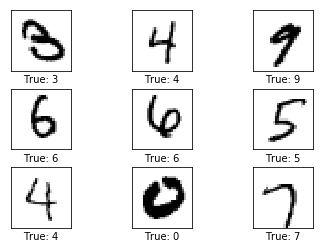

In [7]:
images = x_test[18:27]
cls_true = y_test_cls[18:27]
plot_images(images = images, cls_true=cls_true)

In [8]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != y_test_cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

# Keras Sequential Model
The layers are added in sequence.

In [9]:
# model for stacking the layers in sequence
model = Sequential()

# Input layer 
model.add(InputLayer(input_shape = (img_size_flat,)))

# Reshape input layer from 784 elements to shape of (28,28,1)
model.add(Reshape(img_shape_full))

# First Convolutional layer with ReLu Activation function
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                activation = 'relu', name='layer_conv1'))
# Max-pooling of first layer
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second Convolutional layer with ReLu Activation function
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                activation='relu', name = 'layer_conv2'))

# Max-pooling of second layer
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers to
# 2-rank that can be input to fully-connected/dense layer.
model.add(Flatten())

# Fully-connected layer with ReLu-activation
model.add(Dense(128, activation='relu'))

# Fully-connected layer with Softmax-activation
model.add(Dense(num_classes, activation='softmax'))

In [10]:
# Model compilation
model.compile(optimizer=Adam(lr=1e-3),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [11]:
# Model Training
model.fit(x=x_train,
         y=y_train,
         epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 64s 1ms/step - loss: 0.2175 - acc: 0.9356


In [12]:
# Model Evaluation
result = model.evaluate(x = x_test,
                       y = y_test)

10000/10000 [==============================] - 6s 609us/step


In [13]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.06407192339431494
acc 0.9799


In [14]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 97.99%


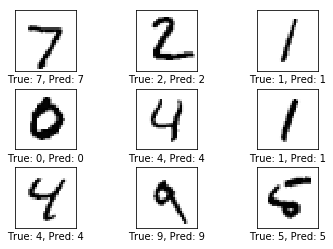

In [15]:
# Model Prediction
images = x_test[0:9]
cls_true = y_test_cls[0:9]
y_pred = model.predict(x=images)
cls_pred = np.argmax(y_pred, axis=1)
plot_images(images=images,
           cls_true=cls_true,
           cls_pred=cls_pred)

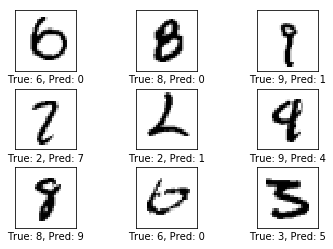

In [16]:
# Mis-Classified Images
y_pred = model.predict(x=x_test)
cls_pred = np.argmax(y_pred, axis=1)
plot_example_errors(cls_pred)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0         
__________

In [18]:
# Save Model
path_model = 'model.keras'
model.save(path_model)

In [19]:
del model

In [20]:
# Load Model
model = load_model(path_model)

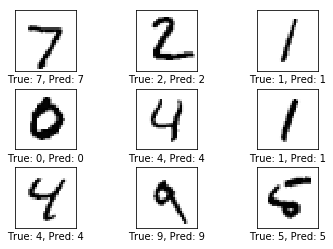

In [21]:
# fetch data
images = x_test[0:9]
cls_true = y_test_cls[0:9]

# predict model
y_pred = model.predict(x=images)
cls_pred = np.argmax(y_pred, axis=1)
plot_images(images=images,
           cls_pred=cls_pred,
           cls_true=cls_true)

---- The End ------